Analysis of Essentia models on the
MTG-Jamendo dataset

In [0]:
#@title
#defining all the path and folder we will need
# we use %%capture for supressing the output of this cell
%%capture

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

Environment set 

In [3]:
#installing essentia
!pip install --upgrade essentia-tensorflow -f https://essentia.upf.edu/python-wheels/


Looking in links: https://essentia.upf.edu/python-wheels/
     |████████████████████████████████| 380.7MB 44kB/s 


In [2]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#@title
#check for the GPU
import psutil
import humanize
import os
import GPUtil as GPU

def printm():
    GPUs = GPU.getGPUs()
    # XXX: only one GPU on Colab and isn’t guaranteed
    gpu = GPUs[0]
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.7 GB  | Proc size: 177.4 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [0]:
#how many tracks do we have to classify 
import os 
import pandas as pd 
import json

In [0]:
#definition of variables path we will need
folder_base = 'drive/My Drive/jamendo_classification/'
track_path = folder_base + 'tracks/'
annotations_path = folder_base + 'annotations/'
model_mood_path = folder_base + 'models/mood/'
model_miscellanous_path = folder_base + 'models/miscellanous/'
sr = 16000
json_results = folder_base + 'predictions/'


In [5]:
single_track_path = []

#collecting file path for each folder in tracks folder
for folder in os.listdir(track_path):
  folder = folder + '/'
  folder_path = os.path.join(track_path, folder)
  for file in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file)
    single_track_path.append(file_path)

print("{} tracks considered ".format(len(single_track_path)))

581 tracks considered: 


In [42]:
#collecting models:
mood_vgg_model = []
mood_cnn_model = []
misc_vgg_model = []
misc_cnn_model = []

#collecting for mood
print("Collecting mood models")
for mood_model in os.listdir(model_mood_path):
  #print("Model {}".format(mood_model))
  if mood_model.split('-')[1] == 'vggish':
    mood_vgg_model.append(model_mood_path + mood_model)
  else:
    mood_cnn_model.append(model_mood_path + mood_model)

print("Mood models vgg: {}".format(mood_vgg_model))
print("Mood model vgg lenght: {}".format(len(mood_vgg_model)))
print("Mood models cnn: {}".format(mood_cnn_model))
print("Mood model cnn lenght: {}".format(len(mood_cnn_model)))

#collecting for misc
print("Collecting miscellanous models")
for misc_model in os.listdir(model_miscellanous_path):
  #print("Model misc {}".format(misc_model))
  if misc_model.split('-')[1] == 'vggish':
    misc_vgg_model.append(model_miscellanous_path + misc_model)
  else:
    misc_cnn_model.append(model_miscellanous_path + misc_model) 

print("Misc models vgg: {}".format(misc_vgg_model))
print("Misc model vgg lenght: {}".format(len(misc_vgg_model)))
print("Misc models cnn: {}".format(misc_cnn_model))
print("Misc model cnn lenght: {}".format(len(misc_cnn_model)))
  

581 tracks considered: 
Mood models vgg: ['drive/My Drive/jamendo_classification/models/mood/mood_happy-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_sad-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_party-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_acoustic-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_aggressive-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_relaxed-vggish-audioset.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_electronic-vggish-audioset.pb']
Mood model vgg lenght: 7
Mood models cnn: ['drive/My Drive/jamendo_classification/models/mood/mood_electronic-musicnn-msd.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_party-musicnn-msd.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_sad-musicnn-msd.pb', 'drive/My Drive/jamendo_classification/models/mood/mood_relaxed-musicnn-msd.pb', 

In [0]:
def dump_json(datafile, prediction):
  with open(datafile, "w+") as fp:
    json.dump(prediction, fp)

In [0]:
def get_prediction(predictions):
  predictions = np.mean(predictions, axis=0)
  #print("Prediciton: ", predictions)
  value = np.argmax(predictions)

  # if we consider index 1 as maximum, we have classified as negation of class 
  if value == 1:
    return 0
  else: return 1

In [13]:
from essentia.standard import *

#get tensorflowmodel_cnn
mood_vgg_modelsList = []
mood_cnn_modelsList = []
misc_vgg_modelsList = []
misc_cnn_modelsList = []

#getting vgg mode models
for mood_vgg_graph in mood_vgg_model:
  mood_vgg_modelsList.append(TensorflowPredictVGGish(graphFilename=mood_vgg_graph))

#getting cnn mode models
for mood_cnn_graph in mood_cnn_model:
  mood_cnn_modelsList.append(TensorflowPredictMusiCNN(graphFilename=mood_cnn_graph))

#getting vgg misc models
for misc_vgg_graph in misc_vgg_model:
  misc_vgg_modelsList.append(TensorflowPredictVGGish(graphFilename=misc_vgg_graph))

#getting cnn misc models
for misc_cnn_graph in misc_cnn_model:
  misc_cnn_modelsList.append(TensorflowPredictMusiCNN(graphFilename=misc_cnn_graph))


print(mood_vgg_modelsList)
print(len(mood_vgg_modelsList))
print(mood_cnn_modelsList)
print(len(mood_cnn_modelsList))
print(misc_vgg_modelsList)
print(len(misc_vgg_modelsList))
print(misc_cnn_modelsList)
print(len(misc_cnn_modelsList))

[<essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e088>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e108>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e148>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e188>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e1c8>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e248>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e288>]
7
[<essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e2c8>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e308>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e348>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e388>, <essentia.standard._create_essentia_class.<locals>.Algo object at 0x7fb00a11e3c8>, 

In [0]:
#classification mood vgg
import numpy as np
#from essentia.standard import *

def classify_mood_vgg(audio, path):

  # dictionary to write to json
  mood_vgg_results = dict()

  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  print('basename:', basename)
  json_path = json_results + 'moodvgg-' + basename + '-results.json' # for each audio clip write results to json

  #print('json_path:', json_path)

  #if we have not allready processed this file, continue...
  if not os.path.exists(json_path):
    model_count = 0
    for vgg_graph in mood_vgg_modelsList:
      #print(model)
      model_name_split = mood_vgg_model[model_count].split('/')
      
      model_name = model_name_split[len(model_name_split)-1][:-3]
      #print("model_name: ", model_name)
      model_class = model_name.split('-')[0]

      # make prediction
      #print("model: {}".format(vgg_graph))
      #model = TensorflowPredictVGGish(graphFilename=vgg_graph)
      predictions = vgg_graph(audio)

       # get class of prediction
      chosen_prediction = get_prediction(predictions)
      #print(chosen_prediction)

      #print('model_class', model_class)
      #print('prediction:', chosen_prediction)
      # update dict.
      mood_vgg_results[model_class] = chosen_prediction

      model_count += 1



     # done dump dictionary to json
    print('done, dumping to json {}'.format(json_path))
    dump_json(json_path, mood_vgg_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [0]:
#classification mood cnn
#import numpy as np
#from essentia.standard import *

def classify_mood_cnn(audio, path):

  # dictionary to write to json
  mood_cnn_results = dict()

  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  print('basename:', basename)
  json_path = json_results + 'moodcnn-' + basename + '-results.json' # for each audio clip write results to json

  #print('json_path:', json_path)

  #if we have not allready processed this file, continue...
  if not os.path.exists(json_path):
    model_count = 0
    for cnn_graph in mood_cnn_modelsList:
      model_name_split = mood_cnn_model[model_count].split('/')
      #print(mood_vgg_model)
      model_name = model_name_split[len(model_name_split)-1][:-3]
      #print("model_name: ", model_name)
      model_class = model_name.split('-')[0]

      # make prediction
      #model = TensorflowPredictMusiCNN(graphFilename=cnn_graph)
      predictions = cnn_graph(audio)

       # get class of prediction
      chosen_prediction = get_prediction(predictions)
      #print(chosen_prediction)

      #print('model_class', model_class)
      #print('prediction:', chosen_prediction)
      # update dict.
      mood_cnn_results[model_class] = chosen_prediction

      model_count += 1



     # done dump dictionary to json
    print('done, dumping to json {}'.format(json_path))
    dump_json(json_path, mood_cnn_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [0]:
#classification misc vgg
#import numpy as np
#from essentia.standard import *

def classify_misc_vgg(audio, path):

  # dictionary to write to json
  misc_vgg_results = dict()

  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  print('basename:', basename)
  json_path = json_results + 'miscvgg-' + basename + '-results.json' # for each audio clip write results to json

  #print('json_path:', json_path)

  #if we have not allready processed this file, continue...
  if not os.path.exists(json_path):
    model_count = 0
    for vgg_graph in misc_vgg_modelsList:
      model_name_split = misc_vgg_model[model_count].split('/')
      #print(mood_vgg_model)
      model_name = model_name_split[len(model_name_split)-1][:-3]
      #print("model_name: ", model_name)
      model_class = model_name.split('-')[0]

      # make prediction
      #print("model: {}".format(vgg_graph))
      #model = TensorflowPredictVGGish(graphFilename=vgg_graph)
      predictions = vgg_graph(audio)

       # get class of prediction
      chosen_prediction = get_prediction(predictions)
      #print(chosen_prediction)

      #print('model_class', model_class)
      #print('prediction:', chosen_prediction)
      # update dict.
      misc_vgg_results[model_class] = chosen_prediction

      model_count += 1



     # done dump dictionary to json
    print('done, dumping to json {}'.format(json_path))
    dump_json(json_path, misc_vgg_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [0]:
#classification for misc cnn 
#import numpy as np
#from essentia.standard import *

def classify_misc_cnn(audio, path):

  # dictionary to write to json
  misc_cnn_results = dict()

  basename = os.path.basename(path)[:-4] # retrieve name of just audio file
  print('basename:', basename)
  json_path = json_results + 'misccnn-' + basename + '-results.json' # for each audio clip write results to json

  #print('json_path:', json_path)

  #if we have not allready processed this file, continue...
  if not os.path.exists(json_path):
    model_count = 0
    for cnn_graph in misc_cnn_modelsList:
      model_name_split = misc_cnn_model[model_count].split('/')
      model_name = model_name_split[len(model_name_split)-1][:-3]
      #print("model_name: ", model_name)
      model_class = model_name.split('-')[0]

      # make prediction
      #print("model: {}".format(cnn_graph))
      #model = TensorflowPredictMusiCNN(graphFilename=cnn_graph)
      predictions = cnn_graph(audio)

       # get class of prediction
      chosen_prediction = get_prediction(predictions)

      #print('model_class', model_class)
      #print('prediction:', chosen_prediction)
      #update dict.
      misc_cnn_results[model_class] = chosen_prediction

      model_count += 1



     # done dump dictionary to json
    print('done, dumping to json {}'.format(json_path))
    dump_json(json_path, misc_cnn_results)
  else:
    print("File json for track {} already computed: {}".format(basename, json_path))



In [15]:
track_count = 0

for track in single_track_path:

  print("File path: {}, track_count: {}/{}".format(track, track_count, len(single_track_path)))

  audio = audio = EasyLoader(filename=track, sampleRate=sr, endTime=180)()

  #classification mood vgg
  print("Classification Mood vgg")
  classify_mood_vgg(audio, track)
  print("\n")

  #classification mood cnn
  #print("Classification Mood cnn")
  #classify_mood_cnn(audio, track)
  #print("\n")

  #classsification misc vgg
  #print("Classification Misc vgg")
  #classify_misc_vgg(audio, track)
  #print("\n")

  #classification misc cnn 
  #print("Classification Misc cnn")
  #classify_misc_cnn(audio, track)
  #print("\n")

  track_count += 1


print("Total track classified: {}".format(track_count))

File path: drive/My Drive/jamendo_classification/tracks/49/1369049.mp3, track_count: 0/581
Classification Mood vgg
basename: 1369049
File json for track 1369049 already computed: drive/My Drive/jamendo_classification/predictions/moodvgg-1369049-results.json


File path: drive/My Drive/jamendo_classification/tracks/49/458249.mp3, track_count: 1/581
Classification Mood vgg
basename: 458249
File json for track 458249 already computed: drive/My Drive/jamendo_classification/predictions/moodvgg-458249-results.json


File path: drive/My Drive/jamendo_classification/tracks/49/1398149.mp3, track_count: 2/581
Classification Mood vgg
basename: 1398149
File json for track 1398149 already computed: drive/My Drive/jamendo_classification/predictions/moodvgg-1398149-results.json


File path: drive/My Drive/jamendo_classification/tracks/49/1029949.mp3, track_count: 3/581
Classification Mood vgg
basename: 1029949
File json for track 1029949 already computed: drive/My Drive/jamendo_classification/predict

Measure of accuracyt

In [6]:
total_mood_vgg = 0
total_mood_cnn = 0
total_misc_cnn = 0
total_misc_vgg = 0

for prediction in os.listdir(json_results):
  if prediction != '.ipynb_checkpoints':
    tipo = prediction.split('-')[0]
    if tipo == 'misccnn':
      total_misc_cnn += 1
    elif tipo == 'moodcnn':
      total_mood_cnn += 1
    elif tipo == 'moodvgg':
      total_mood_vgg += 1
    elif tipo == 'miscgvv':
      total_misc_vgg += 1

print("Total number of misc_cnn: {}".format(total_misc_cnn))
print("Total number of mood_cnn: {}".format(total_mood_cnn))
print("Total number of misc_vgg: {}".format(total_misc_vgg))
print("Total number of mood_vgg: {}".format(total_mood_vgg))

Total number of misc_cnn: 581
Total number of mood_cnn: 581
Total number of misc_vgg: 0
Total number of mood_vgg: 581


In [7]:
#creating dictionary for the two classes - annotation and prediction
prediction_dict = {}
gt_dict = {}

total_prediction = 0
total_gt = 0

#prediction dictionary 
for prediction in os.listdir(json_results):
  if prediction != '.ipynb_checkpoints':
    path = json_results + prediction
    track_id = prediction.split('-')[1]
    #print("fileName: {}".format(prediction))
    if track_id in prediction_dict:
      prediction_dict[track_id].append(path)
    else:
      prediction_dict[track_id] = [path]
    total_prediction += 1



#gt dictionary 
for annotation in os.listdir(annotations_path):
  path = annotations_path + annotation
  track_id = annotation.split('_')[-1].split('.')[0]
  #print("fileName: {}".format(annotation))
  if track_id in gt_dict:
    gt_dict[track_id].append(path)
  else:
    gt_dict[track_id] = [path]

  total_gt += 1

print("Totale number of prediction: {}".format(total_prediction))
print("Total number of annotations: {}".format(total_gt))



Totale number of prediction: 1743
Total number of annotations: 1162


In [0]:
mood_cnn_classification_dict = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_cnn_classification_dict = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

mood_vgg_classification_dict = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_vgg_classification_dict = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

mood_gt_classification_dict = {'mood_acoustic': [], 'mood_aggressive' : [], 
                               'mood_electronic' : [], 'mood_happy' : [],
                               'mood_party' : [], 'mood_relaxed' : [], 'mood_sad' : []}


misc_gt_classification_dict = {'danceability' : [], 'gender' : [], 'tonal_atonal' : [], 
                               'voice_instrumental' : []}

#classification accuracy 

mood_classes = ['mood_happy', 'mood_sad', 'mood_party', 'mood_acoustic', 'mood_aggressive', 'mood_relaxed', 'mood_electronic']
misc_classes = ['tonal_atonal', 'voice_instrumental', 'gender', 'danceability']

mood_cnn_classification = []
mood_vgg_classification = []
misc_cnn_classification = []
misc_vgg_classification = []
mood_gt_classification = []
misc_gt_classification = []

In [25]:

total_track = 0
for track in single_track_path:
  track_id = os.path.basename(track)[:-4]
  #print(total_track)

  if 'mood' in gt_dict[track_id][0]:
    mood_gt = gt_dict[track_id][0]
    misc_gt = gt_dict[track_id][1]
  else:
    mood_gt = gt_dict[track_id][1]
    misc_gt = gt_dict[track_id][0]

    #try to manage this 
  for pred in prediction_dict[track_id]:
    pred_path = pred.split('/')[-1].split('-') 
    if pred_path[0] == 'moodcnn':
      mood_pred_cnn = pred
    elif pred_path[0] == 'moodvgg':
      mood_pred_vgg = pred
    elif pred_path[0] == 'misccnn': 
      misc_pred_cnn = pred
      #add the other 

  with open(mood_gt) as mood_gt, open(misc_gt) as misc_gt, open(mood_pred_cnn) as mood_pred_cnn, open (mood_pred_vgg) as mood_pred_vgg, open(misc_pred_cnn) as misc_pred_cnn:
    mood_gt_dict = json.load(mood_gt)
    misc_gt_dict = json.load(misc_gt)
    mood_pred_cnn_dict = json.load(mood_pred_cnn)
    misc_pred_cnn_dict = json.load(misc_pred_cnn)
    mood_pred_vgg_dict = json.load(mood_pred_vgg)

  for cls in mood_classes:
    mood_gt_classification.append(mood_gt_dict[cls])
    mood_cnn_classification.append(mood_pred_cnn_dict[cls])
    mood_vgg_classification.append(mood_pred_vgg_dict[cls])

  for cls in misc_classes:
    misc_gt_classification.append(misc_gt_dict[cls])
    misc_cnn_classification.append(misc_pred_cnn_dict[cls])
    #misc_vgg_classification.append(mood_pred_vgg_dict[cls])

  for cls in mood_gt_classification_dict.keys():
    mood_gt_classification_dict[cls].append(mood_gt_dict[cls])
    mood_cnn_classification_dict[cls].append(mood_pred_cnn_dict[cls])
    mood_vgg_classification_dict[cls].append(mood_pred_vgg_dict[cls])

  for cls in misc_gt_classification_dict.keys():
    misc_gt_classification_dict[cls].append(misc_gt_dict[cls])
    misc_cnn_classification_dict[cls].append(misc_pred_cnn_dict[cls])

  total_track += 1
    

print("Totale number of tracks: {}".format(total_track))



Totale number of tracks: 581


In [26]:
from sklearn.metrics import accuracy_score

#accuracy scores
mood_gt_classification = list(map(int, mood_gt_classification))
misc_gt_classification = list(map(int, misc_gt_classification))

#accuracy
cnn_mood_accuracy = accuracy_score(mood_gt_classification, mood_cnn_classification)
cnn_misc_accuracy = accuracy_score(misc_gt_classification, misc_cnn_classification)
vgg_mood_accuracy = accuracy_score(mood_gt_classification, mood_vgg_classification)
#vgg_misc_accuracy = accuracy_score(misc_gt_allclassifications, misc_vgg_allclassifications)

print('cnn mood accuracy: ', cnn_mood_accuracy)
print('cnn misc accuracy: ', cnn_misc_accuracy)
print('vgg mood accuracy: ', vgg_mood_accuracy)


cnn mood accuracy:  0.538972215392181
cnn misc accuracy:  0.4208261617900172
vgg mood accuracy:  0.5180722891566265


In [28]:
#single accuarcy for mood cnn
for mood_class in mood_gt_classification_dict.keys():
  gt_mood_class = list(map(int, mood_gt_classification_dict[mood_class]))
  pred_mood_class = mood_cnn_classification_dict[mood_class]
  accuracy_mood_class = accuracy_score(gt_mood_class, pred_mood_class)
  print("Accuracy for class {}: {}".format(mood_class, accuracy_mood_class))

print('\n')
#single accuracy for miscelnnaous cnn 
for misc_class in misc_gt_classification_dict.keys():
  gt_misc_class = list(map(int, misc_gt_classification_dict[misc_class]))
  pred_misc_class = misc_cnn_classification_dict[misc_class]
  accurcay_misc_class = accuracy_score(gt_misc_class, pred_misc_class)
  print("Accuracy for class {}: {}".format(misc_class, accurcay_misc_class))

print('\n')
#single accuarcy for mood vgg
for mood_class in mood_gt_classification_dict.keys():
  #gt_mood_class = list(map(int, mood_gt_classification_dict[mood_class]))
  pred_mood_class_vgg = mood_vgg_classification_dict[mood_class]
  accuracy_mood_class_vgg = accuracy_score(gt_mood_class_vgg, pred_mood_class_vgg)
  print("Accuracy for class {}: {}".format(mood_class, accuracy_mood_class_vgg))



Accuracy for class mood_acoustic: 0.6781411359724613
Accuracy for class mood_aggressive: 0.8898450946643718
Accuracy for class mood_electronic: 0.7469879518072289
Accuracy for class mood_happy: 0.7039586919104991
Accuracy for class mood_party: 0.14113597246127366
Accuracy for class mood_relaxed: 0.23580034423407917
Accuracy for class mood_sad: 0.3769363166953528


Accuracy for class danceability: 0.6712564543889845
Accuracy for class gender: 0.2719449225473322
Accuracy for class tonal_atonal: 0.5679862306368331
Accuracy for class voice_instrumental: 0.1721170395869191


Accuracy for class mood_acoustic: 0.621342512908778
Accuracy for class mood_aggressive: 0.36316695352839934
Accuracy for class mood_electronic: 0.2134251290877797
Accuracy for class mood_happy: 0.46815834767641995
Accuracy for class mood_party: 0.7590361445783133
Accuracy for class mood_relaxed: 0.3442340791738382
Accuracy for class mood_sad: 0.31153184165232356


Class: mood_acoustic
[[0.848      0.152     ]
 [0.40835031 0.59164969]]


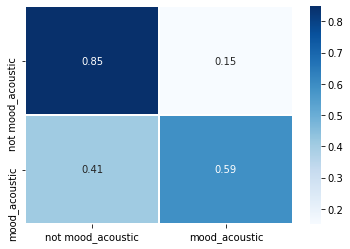

Class: mood_aggressive
[[0.95213923 0.04786077]
 [0.50438596 0.49561404]]


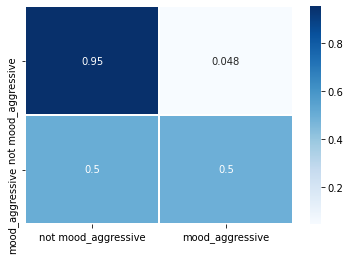

Class: mood_electronic
[[0.88469185 0.11530815]
 [0.30978261 0.69021739]]


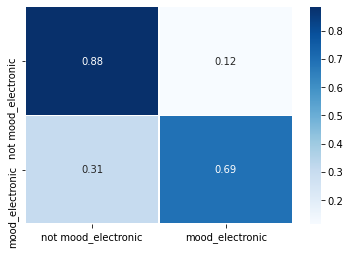

Class: mood_happy
[[0.82833787 0.17166213]
 [0.5513834  0.4486166 ]]


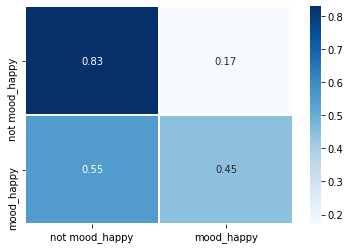

Class: mood_party
[[0.07271364 0.92728636]
 [0.59340659 0.40659341]]


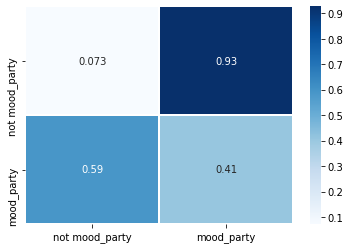

Class: mood_relaxed
[[0.42282958 0.57717042]
 [0.88527919 0.11472081]]


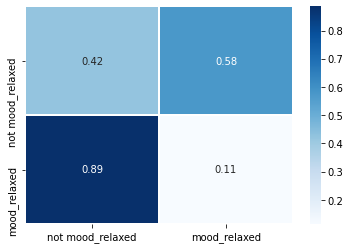

Class: mood_sad
[[0.42397138 0.57602862]
 [0.66462168 0.33537832]]


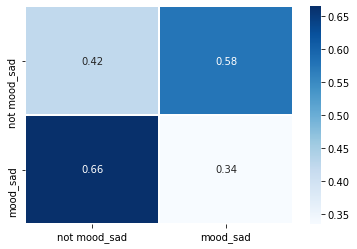

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pylab as plt

# plot all confusion matrix for mood...
for mood_class in mood_gt_classification_dict.keys():
  print('Class:', mood_class)
  matrix_test = confusion_matrix(list(map(int, mood_gt_classification_dict[mood_class])), mood_cnn_classification_dict[mood_class], normalize='true')
  print(matrix_test)
  ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + mood_class, mood_class], yticklabels= ['not ' + mood_class, mood_class])
  plt.show()

Class: danceability
[[0.61341853 0.38658147]
 [0.12394366 0.87605634]]


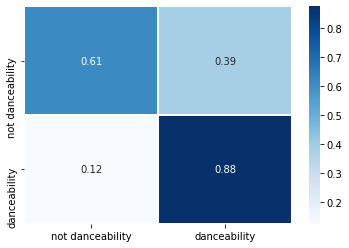

Class: gender
[[0.89903846 0.10096154 0.        ]
 [0.18181818 0.81818182 0.        ]
 [0.35555556 0.64444444 0.        ]]


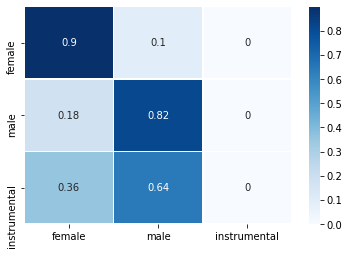

Class: tonal_atonal
[[0.03348214 0.96651786]
 [0.21225194 0.78774806]]


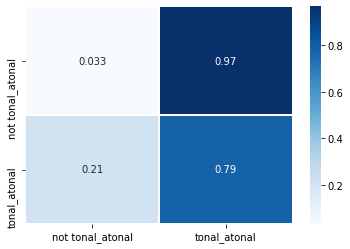

Class: voice_instrumental
[[0.21403197 0.78596803]
 [0.92931393 0.07068607]]


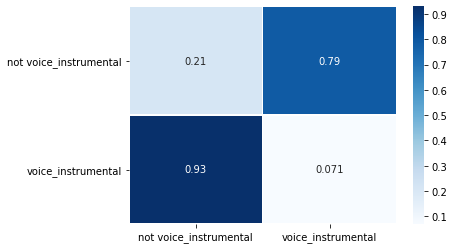

In [138]:
# plot all confusion matrix for misc...
for misc_class in misc_gt_classification_dict.keys():
  print('Class:', misc_class)

  if misc_class == 'gender':
    label = ['female', 'male', 'instrumental']
    matrix_test = confusion_matrix(list(map(int, misc_gt_classification_dict[misc_class])), misc_cnn_classification_dict[misc_class], normalize='true')
    print(matrix_test)
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= label, yticklabels= label)
    plt.show()
  else:
    matrix_test = confusion_matrix(list(map(int, misc_gt_classification_dict[misc_class])), misc_cnn_classification_dict[misc_class], normalize='true')
    print(matrix_test)
    ax = sns.heatmap(matrix_test, linewidth=0.5, annot=True, cmap="Blues", xticklabels= ['not ' + misc_class, misc_class], yticklabels= ['not ' + misc_class, misc_class])
    plt.show()